<a href="https://www.kaggle.com/code/atharvamuley25/inception-googlenet-brain-tumor-mri-classification?scriptVersionId=170662710" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
import keras
import keras.backend as K
import cv2
import pandas as pd
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from tqdm import tqdm
from IPython.display import SVG
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from time import time
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
import tensorflow.keras.backend as K

2024-04-06 15:47:28.597980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 15:47:28.598106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 15:47:28.906545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:01<00:00, 64.43it/s]


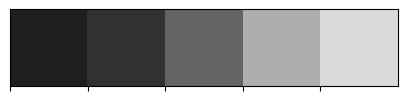

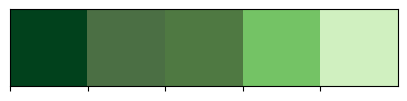

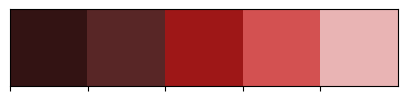

In [5]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

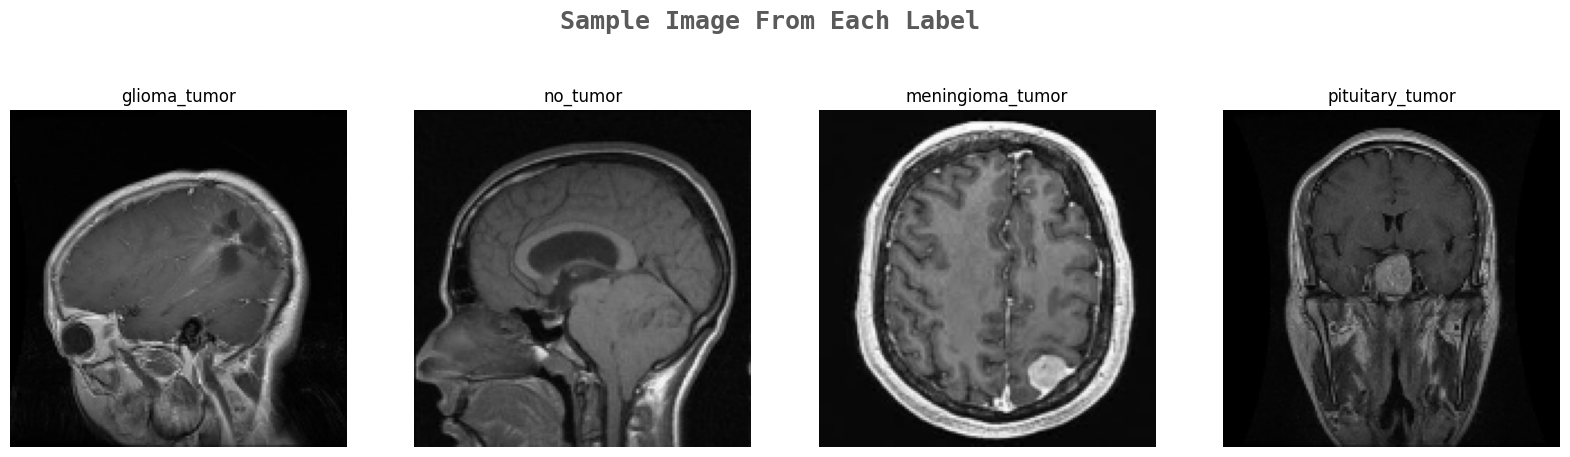

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train.shape

(3264, 150, 150, 3)

In [9]:
y_train.shape

(3264,)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [11]:
X_test.shape

(327, 150, 150, 3)

In [12]:
y_test.shape

(327,)

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Initialize LabelEncoder
encoder = OneHotEncoder()

# Fit and transform labels
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

# Ensure that y_train_encoded has the shape (3264,)
print(y_train_encoded.shape)
print(y_test_encoded.shape)

(2937, 4)
(327, 4)


In [14]:
y_train.shape

(2937,)

In [15]:
def googlenet(input_shape, n_classes):
  
    def inception_block(x, f):
        t1 = Conv2D(f[0], 1, activation='relu')(x)
        
        t2 = Conv2D(f[1], 1, activation='relu')(x)
        t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
        
        t3 = Conv2D(f[3], 1, activation='relu')(x)
        t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)
        
        t4 = MaxPool2D(3, 1, padding='same')(x)
        t4 = Conv2D(f[5], 1, activation='relu')(t4)
        
        output = Concatenate()([t1, t2, t3, t4])
        return output
  
    input = Input(input_shape)
  
    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
  
    x = Conv2D(64, 1, activation='relu')(x)
    x = Conv2D(192, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)
  
    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [128, 128, 192, 32, 96, 64])
    x = MaxPool2D(3, strides=2, padding='same')(x)
  
    x = inception_block(x, [192, 96, 208, 16, 48, 64])
    x = inception_block(x, [160, 112, 224, 24, 64, 64])
    x = inception_block(x, [128, 128, 256, 24, 64, 64])
    x = inception_block(x, [112, 144, 288, 32, 64, 64])
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = inception_block(x, [384, 192, 384, 48, 128, 128])
  
    x = AvgPool2D(5, strides=1)(x)
    x = Dropout(0.4)(x)
  
    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)
  
    model = Model(input, output)
    return model


In [16]:
# Define input shape and number of classes
img_shape = X_train.shape[1:]
n_classes = len(labels)

# Create Inception GoogleNet model
model = googlenet(img_shape, n_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train_encoded, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on test data if available
# Replace X_test and y_test with your test data
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print('Test accuracy:', test_acc)

Epoch 1/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1:06:25 55s/step - accuracy: 0.2500 - loss: 1.8684

I0000 00:00:1712418567.040761      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712418567.106208      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.2777 - loss: 1.8516

W0000 00:00:1712418628.599838      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712418632.397926      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.2779 - loss: 1.8467 - val_accuracy: 0.2874 - val_loss: 1.3402 - learning_rate: 0.0010
Epoch 2/50


W0000 00:00:1712418640.380538      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.3827 - loss: 1.3019 - val_accuracy: 0.4779 - val_loss: 1.1940 - learning_rate: 0.0010
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4629 - loss: 1.2264 - val_accuracy: 0.4643 - val_loss: 1.1919 - learning_rate: 0.0010
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.4742 - loss: 1.1585 - val_accuracy: 0.5034 - val_loss: 1.0260 - learning_rate: 0.0010
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5552 - loss: 0.9602 - val_accuracy: 0.5153 - val_loss: 1.0761 - learning_rate: 0.0010
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5516 - loss: 0.9371 - val_accuracy: 0.6241 - val_loss: 0.8492 - learning_rate: 0.0010
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5748 - loss: 0.8853 - val_accuracy: 0.6310 - val_loss: 0.8208 - learning_rate: 0.0010
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6550 - loss: 0.7547 - val_accuracy: 0.59

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print('Test accuracy:', test_acc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 731ms/step - accuracy: 0.8517 - loss: 0.5370
Test accuracy: 0.856269121170044


W0000 00:00:1712418752.075241      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 75, 75,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 38, 38,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 38, 38,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 38, 38,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 18, 18,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 18, 18,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 18, 18,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 18, 18,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 18, 18,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 18, 18,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 18, 18,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 18, 18,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 18, 18,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 18, 18,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 18, 18,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                 

 Total params: 17,932,958 (68.41 MB)

 Trainable params: 5,977,652 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,955,306 (45.61 MB)

In [19]:
def plot_training_curves(history):
    loss= np.array(history.history['loss'])
    val_loss= np.array(history.history['val_loss'])
    
    accuracy= np.array(history.history['accuracy'])
    val_accuracy= np.array(history.history['val_accuracy'])
    
    epochs= range(len(history.history['loss']))
    
    fig, (ax1, ax2)= plt.subplots(1,2,figsize=(10,3))
    
    #plot loss
    ax1.plot(epochs, loss, label='traing_loss', marker='o')
    
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs,loss, val_loss, where=(loss>val_loss),color='C0',alpha=0.3,interpolate=True)
    ax1.fill_between(epochs,loss, val_loss, where=(loss<val_loss),color='C1',alpha=0.3,interpolate=True)
    
    ax1.set_title('Loss(Lower Means Better)',fontsize= 16)
    ax1.set_xlabel('Epochs', fontsize=10)
    
    ax1.legend()
    
    #plot Accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy>val_accuracy),color='C0',alpha=0.3,interpolate=True)
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy<val_accuracy),color='C1',alpha=0.3,interpolate=True)
    
    ax2.set_title('Accuracy(Higher Means Better)',fontsize= 16)
    ax2.set_xlabel('Epochs', fontsize=10)
    
    ax2.legend()

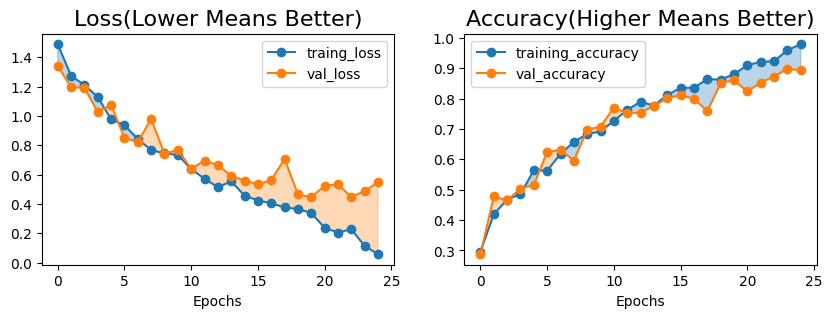

In [20]:
plot_training_curves(history)

In [21]:
xtest = X_test
ytest = y_test_encoded
ypred = model.predict(xtest)

total = len(ytest)
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
print('Total test data:', total)
print('Accurately predicted data:', accurate)
print('Wrongly predicted data:', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

W0000 00:00:1712418758.184594      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step
Total test data: 327
Accurately predicted data: 280
Wrongly predicted data: 47
Accuracy: 85.627 %


W0000 00:00:1712418761.722456      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


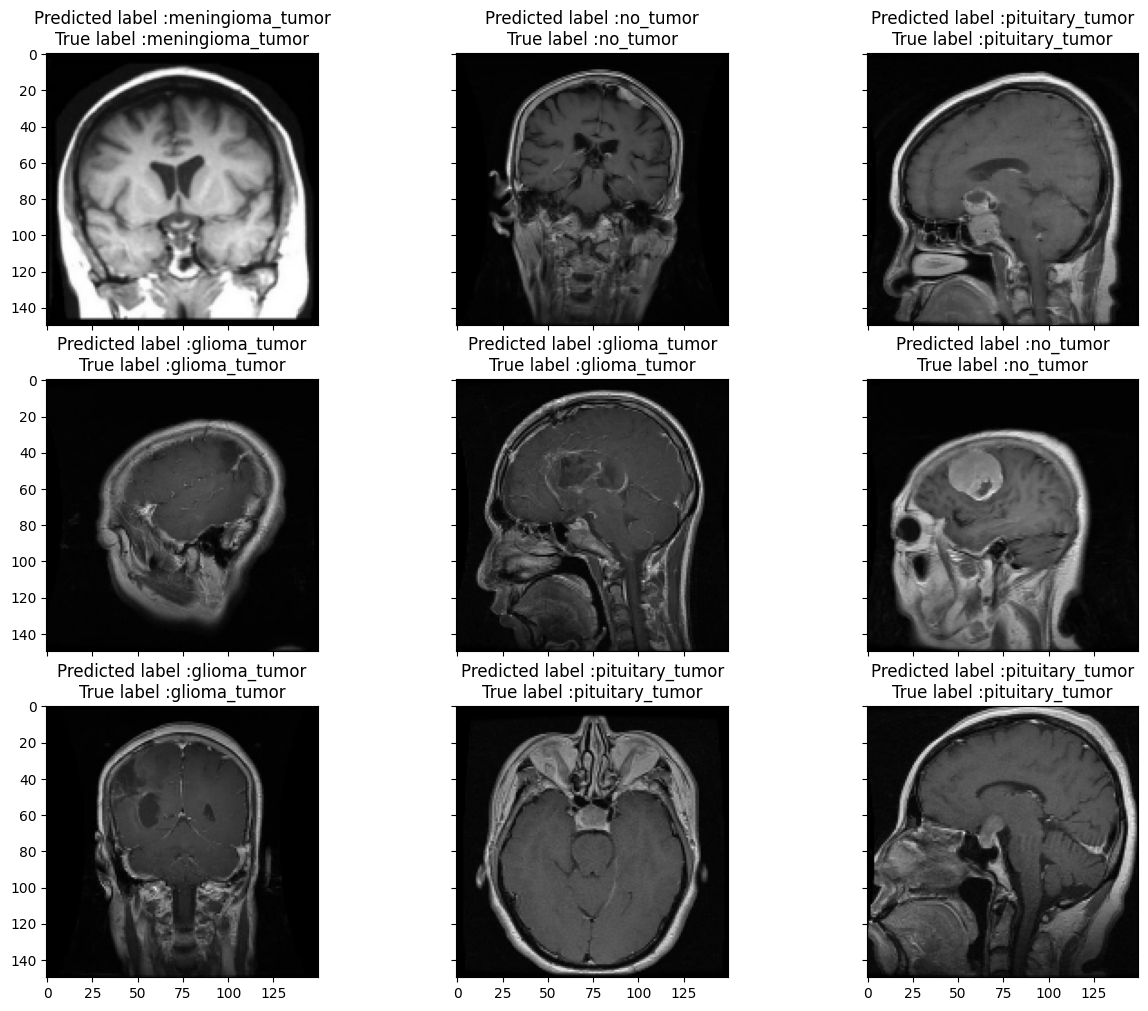

In [22]:
import random
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(labels[np.argmax(ypred[imidx[n]])], labels[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

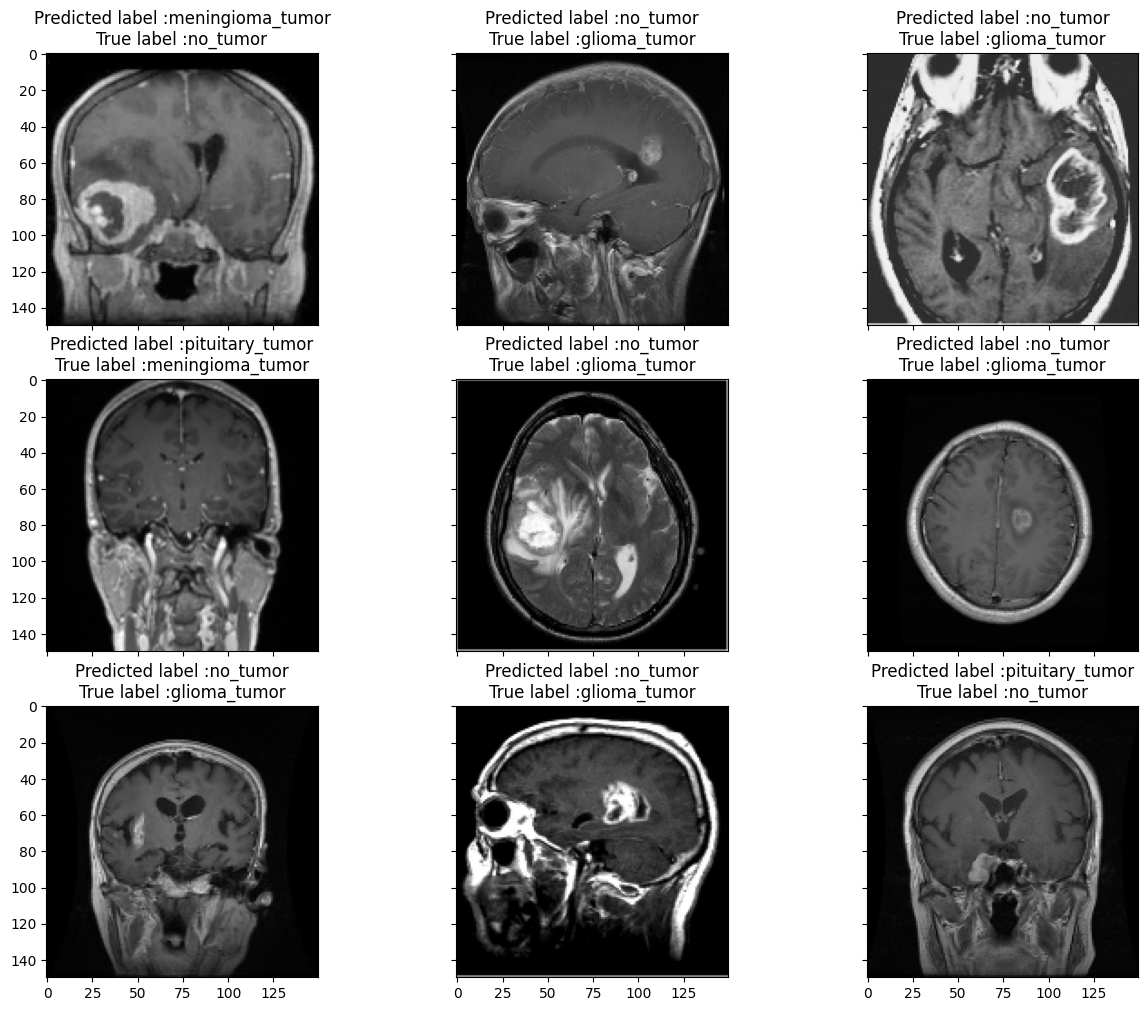

In [23]:
import random
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
imidx = random.sample(wrongindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(labels[np.argmax(ypred[imidx[n]])], labels[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()